In [6]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import random
import copy
import os

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def sigmoid(x, deriv=False):
    if deriv:
        return sigmoid(x)*(1 - sigmoid(x))
    return 1/(1+np.exp(-x))

In [16]:
class Network:
    def __init__(self, shape = [2, 3, 1]):
        if len(shape) < 2:
            raise Exception("Shape needs at least 2 entries, input and output")
        
        self.shape = shape
        self.input_size = self.shape[0]
        self.output_size = self.shape[-1]
        
        self.num_layers = len(self.shape)
        
        self.hidden_sizes = self.shape[1:-1]
        
        self.activ = sigmoid
    
        self.weights = [np.random.random([self.shape[i],self.shape[i+1]]) for i in range(self.num_layers - 1)]
        self.biases = [np.random.random([1, self.shape[i+1]]) for i in range(self.num_layers - 1)]
        
        self.iter = 0
    
    def feed_forward(self, input_x, return_network = False):
        layer_vals = [input_x]
        
#         input_x.reshape([self.input_size, len(input_x)])
        
        if len(input_x[0]) != self.input_size:
            raise Exception("Input size must be equal to input layer size. {} not working with {}".format(input_x.shape, self.input_size))
        
        for layer_num in range(1, len(self.weights)+1):
            # Apply activ( B + X * M ), 
            layer_vals.append(
                self.activ( # activation function
                    self.biases[layer_num-1] +  # B (biases)
                    np.dot(
                        layer_vals[-1], # X ( the values of the nodes in the previous layer )
                        self.weights[layer_num-1]) # M ( the weights )
                        
                )
            )
        if return_network:
            return layer_vals
        return layer_vals[-1]
    
    def train(self, input_x, output_y, learning_rate = 0.03):
        self.backpropogate(input_x, output_y, learning_rate, return_loss = True)
        
        print(self.cost(input_x, output_y))
    
    def error(self, input_x, output_y):
        y_hat = self.feed_forward(input_x)
        if y_hat.shape != output_y.shape:
            raise Exception("whahoh")
        
        return output_y - y_hat
    
    def cost(self, input_x, output_y):
        total_cost = 0
        
        y_hat = self.feed_forward(input_x)
        
        return np.sum(np.square(y_hat - output_y.reshape([len(output_y), self.output_size])))/len(output_y)
    
    def get_max_error(self, input_x, output_y):
        y_hat = self.feed_forward(input_x)
        err = np.abs(y_hat - output_y)
        return np.max(err)
    
    def stoch_grad_desc(self, input_x, output_y, learning_rate, return_loss = False):
        weight_shapes = [w.shape for w in self.weights]
        weight_noise = [np.random.random(w_shape) for w_shape in weight_shapes]
        
        nn_minus = copy.deepcopy(self)
        nn_plus = copy.deepcopy(self)
        for weight_index in range(len(weight_noise)):
            nn_minus.weights[weight_index] -= learning_rate*weight_noise[weight_index]
            nn_plus.weights[weight_index]  += learning_rate*weight_noise[weight_index]
            
        nn_minus_eval = nn_minus.cost(input_x, output_y)
        nn_plus_eval = nn_plus.cost(input_x, output_y)
        self_eval = self.cost(input_x, output_y)

#         nn_minus_eval = nn_minus.get_max_error(input_x, output_y)
#         nn_plus_eval = nn_plus.get_max_error(input_x, output_y)
#         self_eval = self.get_max_error(input_x, output_y)
        
        if nn_minus_eval < nn_plus_eval:
            if nn_minus_eval < self_eval:
                self.weights = nn_minus.weights
        elif nn_plus_eval < nn_minus_eval:
            if nn_plus_eval < self_eval:
                self.weights = nn_plus.weights
            
        
    
    def backpropogate(self, input_x, output_y, learning_rate, return_loss = False):
        # cost = self.cost(input_x, output_y)
        for row in range(len(input_x)):
            self.iter += 1
            row_x = input_x[row].reshape([1, self.input_size])
            row_y = output_y[row].reshape([1, self.output_size])
#             err_main = self.error(row_x, row_y)
            layer_vals = self.feed_forward(row_x, return_network = True)
            
        
            # Delta weights = lr * Vals * _____ * errors
            if row_y.shape != layer_vals[-1].shape:
                raise Exception("targets and predictions are not the same shape! {} and {}".format(row_y.shape, layer_vals[-1].shape))
            err_final = (row_y - layer_vals[-1]).transpose()
            
            # Calculate errors associated with each node
            errors = [err_final]
            for layer_index in list(range(self.num_layers - 1))[::-1]:
                output = layer_vals[layer_index+1]
                if errors[-1].transpose().shape != output.shape:
                    raise Exception("errors.T and outputs not the same. {} and {}".format(errors[-1].transpose().shape, output.shape))
                gradient = learning_rate*errors[-1].transpose()*(output*(1-output))
                errors.append(np.dot(self.weights[layer_index], errors[-1]))
#                 print(gradient.shape)
#                 print(self.biases[layer_index].shape)
#                 print(layer_vals[1+layer_index].shape)
#                 print(layer_vals[layer_index].shape)
                delta = np.dot(layer_vals[layer_index].transpose(), gradient)
                self.weights[layer_index] += delta
                self.biases[layer_index] += gradient
        
    def save(self, name = "untitled", random_nums = True):
        if random_nums:
            folder_name = "{}_{}".format(name, np.random.randint(1000, 9999))
        else:
            folder_name = name
        os.mkdir(folder_name)
            
        for w_index in range(len(self.weights)):
            np.save("{}/Weights_{}".format(folder_name, w_index), self.weights[w_index])
        for b_index in range(len(self.biases)):
            np.save("{}/Biases_{}".format(folder_name, b_index), self.biases[b_index])
        
    def load(self, directory):
        for w_index in range(len(self.weights)):
            self.weights[w_index] = np.load("{}/Weights_{}.npy".format(directory, w_index))
        for b_index in range(len(self.biases)):
            self.biases[b_index] = np.load("{}/Biases_{}.npy".format(directory, b_index))            

## Let's test whether this works!

### Using (what I am calling) The modified XOR problem!

3 Inputs: `x`, `y`, `z`

2 Outputs: `(x XOR y) XOR z`, `(x XOR y)`

%	Cost
0.0%	0.7933671046913763
10.0%	0.12832692433477022
20.0%	0.07348443988729679
30.0%	0.06583719787039119
40.0%	0.06436882004990402
50.0%	0.06350773154072946
60.0%	0.01800799669404496
70.0%	0.004780372024684726
80.0%	0.002734421864192158
90.0%	0.001973135123750131


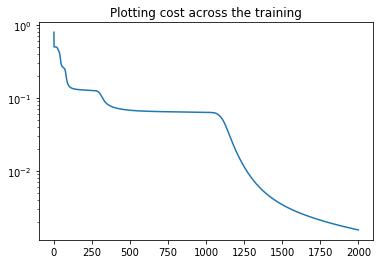

Final cost: 0.0015557773993672194
The final guesses after training:
[[0.003 0.02 ]
 [0.94  0.959]
 [0.975 1.   ]
 [0.003 0.02 ]
 [0.999 0.029]
 [0.05  1.   ]
 [0.032 0.974]
 [0.999 0.027]]


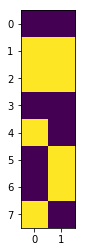

Which is similar to the targets:
[[0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]


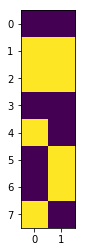

In [17]:
xor_nn = Network(shape = [3, 4 , 2])
# 2 inputs, 2 hidden layers of size 3 and 5, and 1 output! 

# Let us define the training set for the XOR problem

training_x = np.array([
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1]
])

training_y = np.array([
    [0, 0],
    [1, 1],
    [1, 1],
    [0, 0],
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0],
])
# Lets conduct the training!
cost = []
iters = 100000
print("%\tCost")
for i in range(iters):
    xor_nn.backpropogate(training_x, training_y, 0.05)
    if i %50 == 0:
        cost.append(xor_nn.cost(training_x, training_y))
    if i % int(iters/10) == 0:
        print("{}%\t{}".format(round(100*i/iters, 2), xor_nn.cost(training_x, training_y)))
plt.plot(cost)
plt.yscale('log')
plt.title("Plotting cost across the training")
plt.show()
print("Final cost: {}".format(xor_nn.cost(training_x, training_y)))
print("The final guesses after training:")
print(np.round(xor_nn.feed_forward(training_x), 3))
plt.imshow(np.round(xor_nn.feed_forward(training_x)))
plt.show()
print("Which is similar to the targets:")
print(training_y)
plt.imshow(training_y)
plt.show()

Let us try saving the model and reloading it, to see if our saving functionality works!

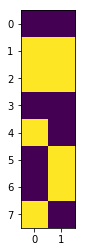

In [20]:
xor_nn.save("xor_nn", False)
xor_nn_2 = Network(shape = [3, 4 , 2])
xor_nn_2.load("xor_nn")
plt.imshow(np.round(xor_nn_2.feed_forward(training_x)))
plt.show()

Nice, so with all this, let us attempt the MNIST hand written digit classification problem!

In [147]:
mnist_nn = Network(shape = [28*28, 200, 10])
print(mnist_nn.shape)

[784, 200, 10]


In [148]:
mnist_costs = []

## Training!!!

Let us create some Experiment running methods!

In [151]:
def backprop(nn, x, y, lr):
    nn.backpropogate(x, y, lr)
def stoch_grad_desc(nn, x, y, lr):
    nn.stoch_grad_desc(x, y, lr)

def running_avg(x, n=2):

    running_mean = x

    run_length = n

    for i in range(1, run_length):
        running_mean = running_mean + np.concatenate((np.zeros([i]), x[:-(i)]))
    return running_mean/run_length

def plot_last_20():
    plt.plot(running_avg(mnist_costs, 20))
    
def mnist_experiment(lr, learning_funct = backprop, iters = 80000):
    mnist_lr = lr
    curr_score = 0
    score_count = 0
    # Lets conduct the training!
    for i in range(iters):
        x_batch, y_true_batch = mnist_data.train.next_batch(100)
        learning_funct(mnist_nn, x_batch, y_true_batch, mnist_lr)
#         mnist_nn.backpropogate(x_batch, y_true_batch, mnist_lr)
        if (i+1) %10 == 0:
            curr_score = np.sum(np.argmax(y_true_batch, axis = 1) == np.argmax(mnist_nn.feed_forward(x_batch), axis = 1))
            score_count += 1
            mnist_costs.append(mnist_nn.cost(x_batch, y_true_batch))
            if (i+1) %int(iters/10) == 0:
                print("{:.0f}%\t{:.5f}".format(
                    (i+1)*100/iters, 
                    np.sum(np.argmax(y_true_batch, axis = 1) == np.argmax(mnist_nn.feed_forward(x_batch), axis = 1))))
                curr_score = 0
                score_count = 0


#     plt.plot(mnist_costs)
    plot_last_20()
    plt.yscale('log')
    plt.title("Plotting cost across the training")
    plt.show()

    x_batch, y_true_batch = mnist_data.train.next_batch(1000)
    answers = np.argmax(y_true_batch, axis = 1)
    guesses = mnist_nn.feed_forward(x_batch)
    confusion_mat = np.zeros([10,10])

    for i in range(len(answers)):
        confusion_mat[answers[i]]+= guesses[i]

    plt.imshow(confusion_mat)
    plt.xlabel("Guess")
    plt.ylabel("Target")
    plt.title("Confusion Matrix: Guesses vs Targets")
    plt.show()

10%	11.00000
20%	5.00000
30%	10.00000
40%	17.00000
50%	10.00000
60%	14.00000
70%	15.00000
80%	14.00000
90%	13.00000
100%	7.00000


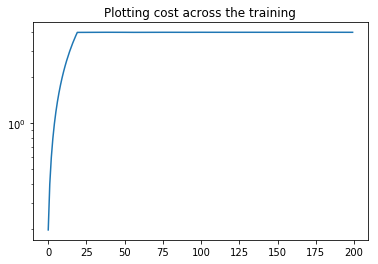

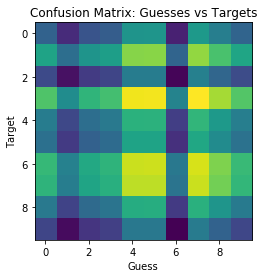

In [152]:
mnist_experiment(15, stoch_grad_desc, 1000)

10%	7.00000
20%	10.00000
30%	11.00000
40%	7.00000
50%	10.00000
60%	13.00000
70%	9.00000
80%	8.00000
90%	5.00000
100%	12.00000


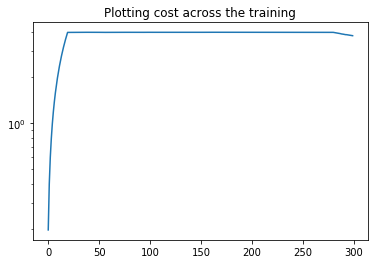

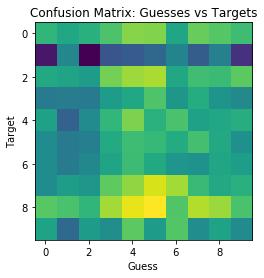

In [153]:
mnist_experiment(5, stoch_grad_desc, 1000)

10%	9.00000
20%	13.00000
30%	7.00000
40%	11.00000
50%	8.00000
60%	13.00000
70%	5.00000
80%	13.00000
90%	7.00000
100%	7.00000


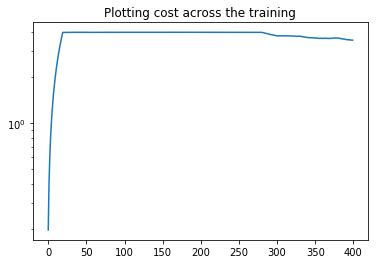

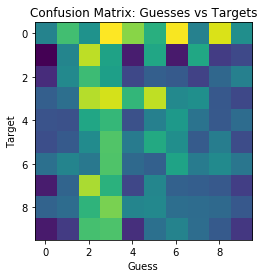

In [154]:
mnist_experiment(5, stoch_grad_desc, 1000)

10%	10.00000
20%	12.00000
30%	12.00000
40%	11.00000
50%	11.00000
60%	7.00000
70%	7.00000
80%	19.00000
90%	11.00000
100%	17.00000


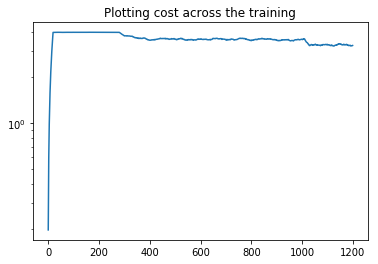

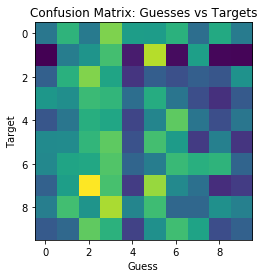

In [155]:
mnist_experiment(5, stoch_grad_desc, 8000)

10%	5.00000
20%	8.00000
30%	9.00000
40%	13.00000
50%	17.00000
60%	19.00000
70%	19.00000
80%	22.00000
90%	28.00000
100%	20.00000


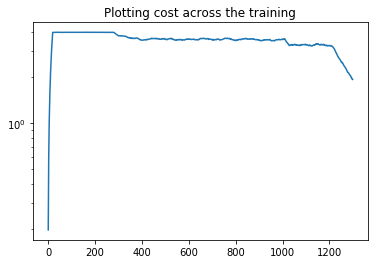

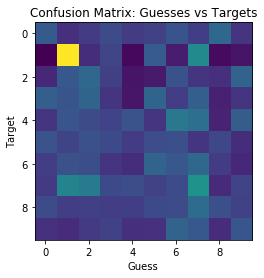

In [156]:
mnist_experiment(0.001, backprop, 1000)

In [157]:
mnist_nn.save("mnist_imporiving", False)

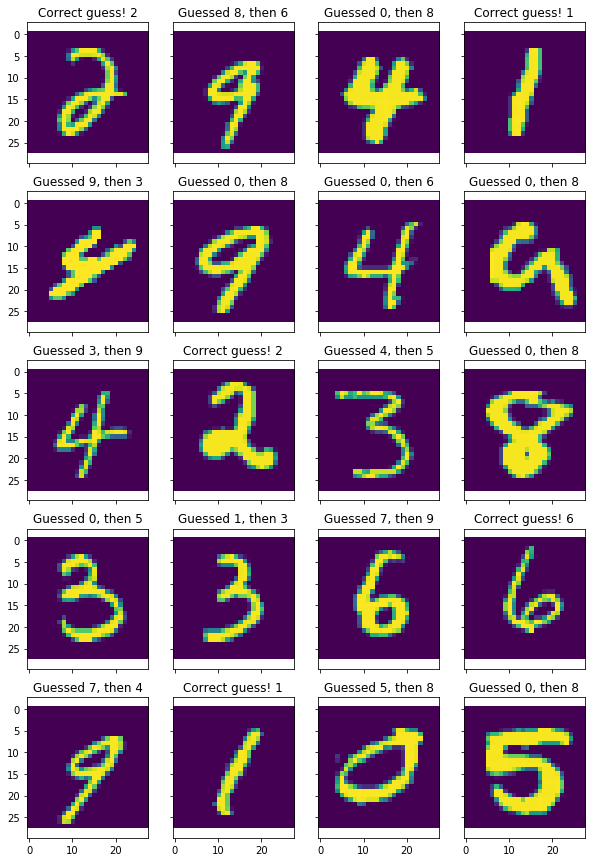

In [159]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharex=True, sharey=True)

fig.set_figheight(15)
fig.set_figwidth(10)

for i, ax in enumerate(axes.flat):
    ans = np.argmax(y_true_batch[i])
    guesses = np.argsort(mnist_nn.feed_forward(x_batch)[i])
    if ans == guesses[-1]:
        msg = "Correct guess! {}".format(guesses[-1])
    else:
        msg = "Guessed {}, then {}".format(guesses[-1], guesses[-2])
    ax.set_title(msg)
    ax.imshow( x_batch[i].reshape([28,28]))

plt.show()

10%	25.00000
20%	27.00000
30%	31.00000
40%	20.00000
50%	17.00000
60%	15.00000
70%	21.00000
80%	25.00000
90%	20.00000
100%	26.00000


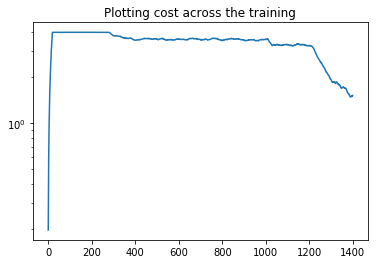

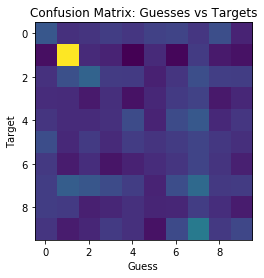

In [160]:
mnist_experiment(0.001, backprop, 1000)

10%	32.00000
20%	25.00000
30%	34.00000
40%	22.00000
50%	26.00000
60%	24.00000
70%	24.00000
80%	28.00000
90%	26.00000
100%	23.00000


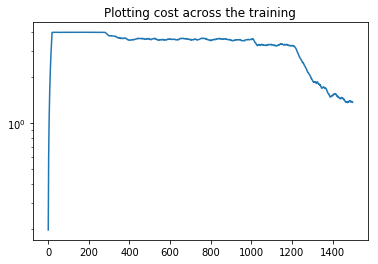

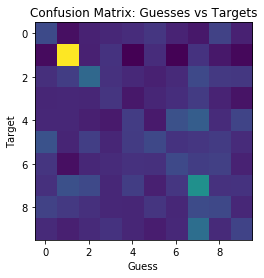

In [161]:
mnist_experiment(0.001, backprop, 1000)

10%	35.00000
20%	29.00000
30%	23.00000
40%	25.00000
50%	32.00000
60%	29.00000
70%	27.00000
80%	27.00000
90%	30.00000
100%	29.00000


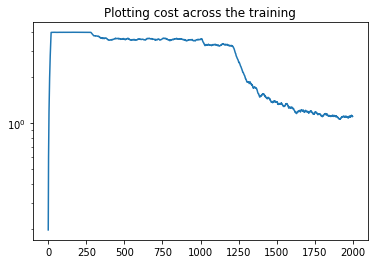

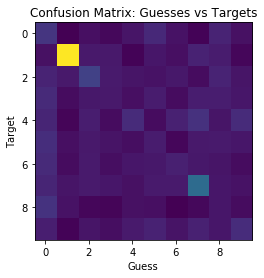

In [162]:
mnist_experiment(0.001, backprop, 5000)

In [163]:
mnist_nn.save("mnist_getting_very_cool", False)

10%	23.00000
20%	29.00000
30%	29.00000
40%	26.00000
50%	27.00000
60%	29.00000
70%	24.00000
80%	26.00000
90%	22.00000
100%	24.00000


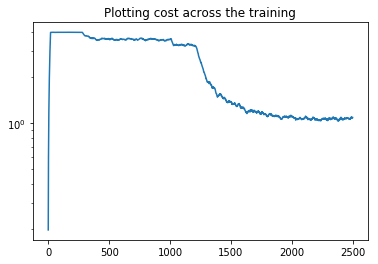

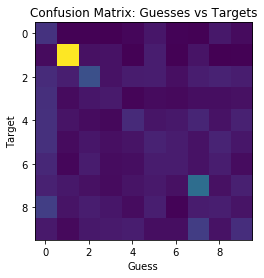

In [164]:
mnist_experiment(0.0003, backprop, 5000)

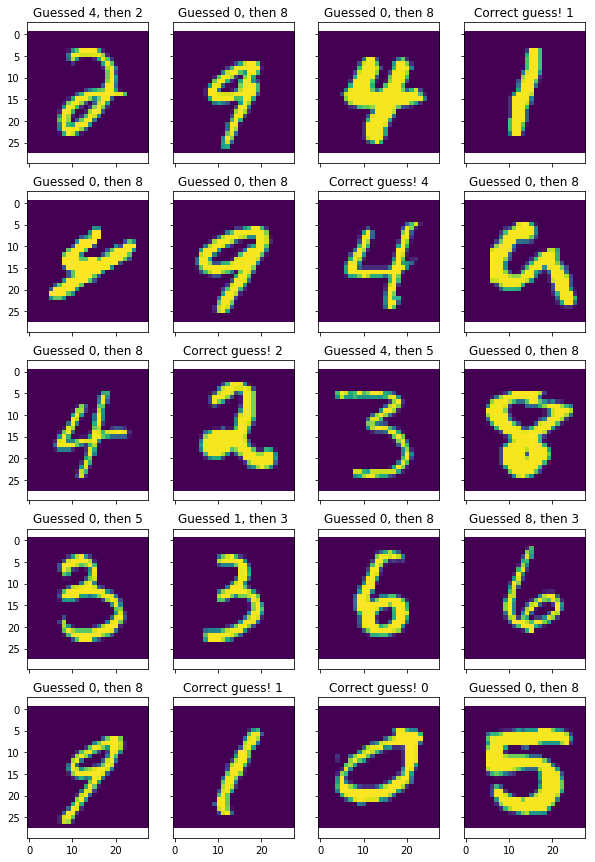

In [165]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharex=True, sharey=True)

fig.set_figheight(15)
fig.set_figwidth(10)

for i, ax in enumerate(axes.flat):
    ans = np.argmax(y_true_batch[i])
    guesses = np.argsort(mnist_nn.feed_forward(x_batch)[i])
    if ans == guesses[-1]:
        msg = "Correct guess! {}".format(guesses[-1])
    else:
        msg = "Guessed {}, then {}".format(guesses[-1], guesses[-2])
    ax.set_title(msg)
    ax.imshow( x_batch[i].reshape([28,28]))

plt.show()

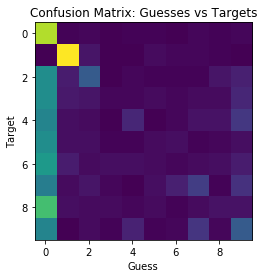

In [168]:
x_batch, y_true_batch = mnist_data.train.next_batch(1000)
answers = np.argmax(y_true_batch, axis = 1)
guesses = np.argmax(mnist_nn.feed_forward(x_batch), axis = 1)
confusion_mat = np.zeros([10,10])

for i in range(len(answers)):
    confusion_mat[answers[i]][guesses[i]]+=1

plt.imshow(confusion_mat)
plt.xlabel("Guess")
plt.ylabel("Target")
plt.title("Confusion Matrix: Guesses vs Targets")
plt.show()

In [170]:
mnist_nn.save("mnist_greatest", False)

10%	28.00000
20%	32.00000
30%	28.00000
40%	24.00000
50%	22.00000
60%	26.00000
70%	31.00000
80%	38.00000
90%	34.00000
100%	25.00000


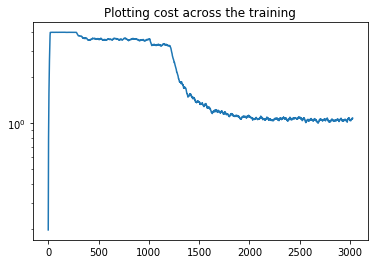

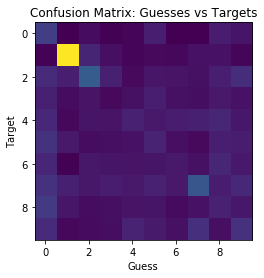

In [171]:
mnist_experiment(0.00007, backprop, 5000)

This is the best it is going to get